
Привет, меня зовут Люман Аблаев. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на красные комментарии ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:


<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>







<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление</font>
* Спасибо за очень качественную работу - видно, что приложено много усилий,
- Я оставил некоторые советы, надеюсь они будут полезными и интересными
- Есть некоторые недочеты, которые нужно поправить, но у тебя это не должно занять много времени)
- Жду обновленную работу

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Загрузка данных данных

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from numpy.random import RandomState

In [77]:
pd.set_option('display.max_colwidth', None)

In [78]:
try:
    df = pd.read_csv('./datasets/autos.csv') 
except:
    df = pd.read_csv('/datasets/autos.csv')

In [79]:
START_DATA_SIZE = df.shape[0]
RANROM_STATE = RandomState(42)
RANDOM_STATE_FOR_CAT_BOOST = 42


<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  и настройки на месте
</div>



## Вспомогательные функции

In [80]:
def get_info_about_dataset(df):
    separate_line = '+' + 100*'-' + '+'
    print(separate_line)
    print('Первые 5 строк датасета:')
    display(df.head())
    print(separate_line)
    print('Информация о датасете:')
    display(df.info())
    print(separate_line)
    print('Описательная статистика:')
    display(df.describe())
    print(separate_line)
    print('Количество пропусков:')
    info_about_mising = {
        'Кол-во пропусков': df.isna().sum(),
        'Процент пропусков': round(df.isna().sum()/START_DATA_SIZE * 100, 2)
    } 
    display(pd.DataFrame(info_about_mising))
    print(separate_line)
    print('Количество дубликатов: ', df.duplicated().sum())
    print(separate_line)
    print('Корреляция Пирсона:')
    corr_matrix = df.corr()
    display(corr_matrix)
    sns.heatmap(corr_matrix).set_title('Корреляция Пирсона')
    print(separate_line)

In [81]:
def research_feature(df, column):
    print(f'Анализ признака {column}')
    separate_line = '+' + 100 * '-' + '+'
    print(separate_line)
    print('Описательная статистика:')
    display(df[column].describe())
    print(separate_line)
    print(f'Количество пропусков: {df[column].isna().sum()}')
    print(f'Процент пропусков: {df[column].isna().sum() / START_DATA_SIZE:.2%}')
    print(separate_line)

In [82]:
def research_numerical_feature(df, column):
    research_feature(df, column)
    _, ax = plt.subplots(figsize=(20, 10))
    ax.xaxis.grid(True)
    sns.violinplot(
        data=df,
        x=column, ax=ax
    ).set_title(f'Распределение признака {column}')

In [83]:
def research_categorical_features(df, column):
    research_feature(df, column)
    _, ax = plt.subplots(figsize=(20, 10))
    ax.xaxis.grid(True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict= { 'fontsize': 12})
    sns.countplot(
        data=df,
        x=column, ax=ax
    ).set_title(f'Распределение признака {column}')

In [84]:
def ohe(df, encoder, columns):
    encoder_categorical = pd.DataFrame(
        encoder.transform(df[columns]).toarray(),
        index=df.index,
        columns=encoder.get_feature_names()
    )
    df = df.join(encoder_categorical)
    df.drop(columns, inplace=True, axis=1)
    return df

In [85]:
def research_model(model, params, features, target, cv=5, fit_params={}):
    gscv = GridSearchCV(
        model, params, cv=cv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        refit=False,
        return_train_score=True,
    )
    gscv.fit(features, target, **fit_params)
    return pd.DataFrame(gscv.cv_results_).sort_values(
        by='mean_test_score', ascending=False
    )


<div class="alert alert-block alert-success">
<b>Успех:</b> Хорошие помощники
</div>



## Загрузка данных данных

In [86]:
df = pd.read_csv('./datasets/autos.csv')

In [87]:
START_DATA_SIZE = df.shape[0]

## Исследовательский анализ и предобратботка данных

+----------------------------------------------------------------------------------------------------+
Первые 5 строк датасета:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


+----------------------------------------------------------------------------------------------------+
Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  in

None

+----------------------------------------------------------------------------------------------------+
Описательная статистика:


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


+----------------------------------------------------------------------------------------------------+
Количество пропусков:


,Кол-во пропусков,Процент пропусков
DateCrawled,0,0.00
Price,0,0.00
VehicleType,37490,10.58
RegistrationYear,0,0.00
Gearbox,19833,5.60
Power,0,0.00
Model,19705,5.56
Kilometer,0,0.00
RegistrationMonth,0,0.00
FuelType,32895,9.28


+----------------------------------------------------------------------------------------------------+
Количество дубликатов:  4
+----------------------------------------------------------------------------------------------------+
Корреляция Пирсона:


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


+----------------------------------------------------------------------------------------------------+


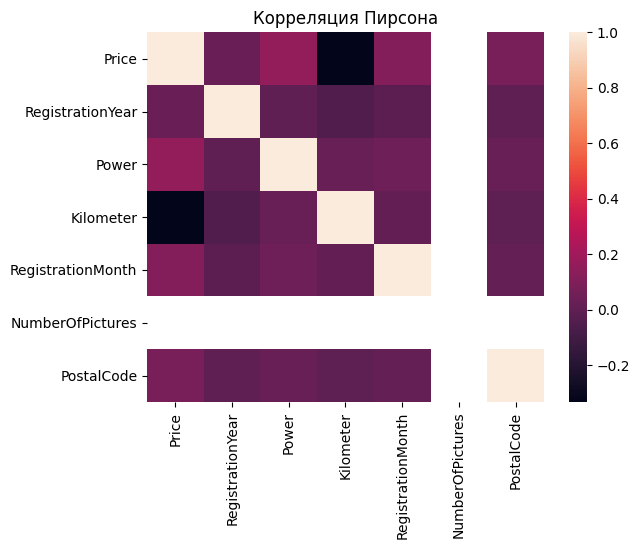

In [88]:
get_info_about_dataset(df)

Перед анализом признаков исключим из датасета следующие признаки:  
* `DateCrawled ` - дата скачивания анкеты из базы  
* `RegistrationMonth` - месяц регистрации автомобиля  
* `DateCreated` - дата создания анкеты. Так как в рамках данного проекта не будет учитываться инфляция цен  
* `PostalCode` - почтовый индекс владельца анкеты (пользователя)  
* `LastSeen` - дата последней активности пользователя

### Признак Brand - марка автомобиля

Анализ признака Brand
+----------------------------------------------------------------------------------------------------+
Описательная статистика:


count         354369
unique            40
top       volkswagen
freq           77013
Name: Brand, dtype: object

+----------------------------------------------------------------------------------------------------+
Количество пропусков: 0
Процент пропусков: 0.00%
+----------------------------------------------------------------------------------------------------+


C:\Users\Alexander\AppData\Local\Temp\ipykernel_12824\3896368005.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict= { 'fontsize': 12})


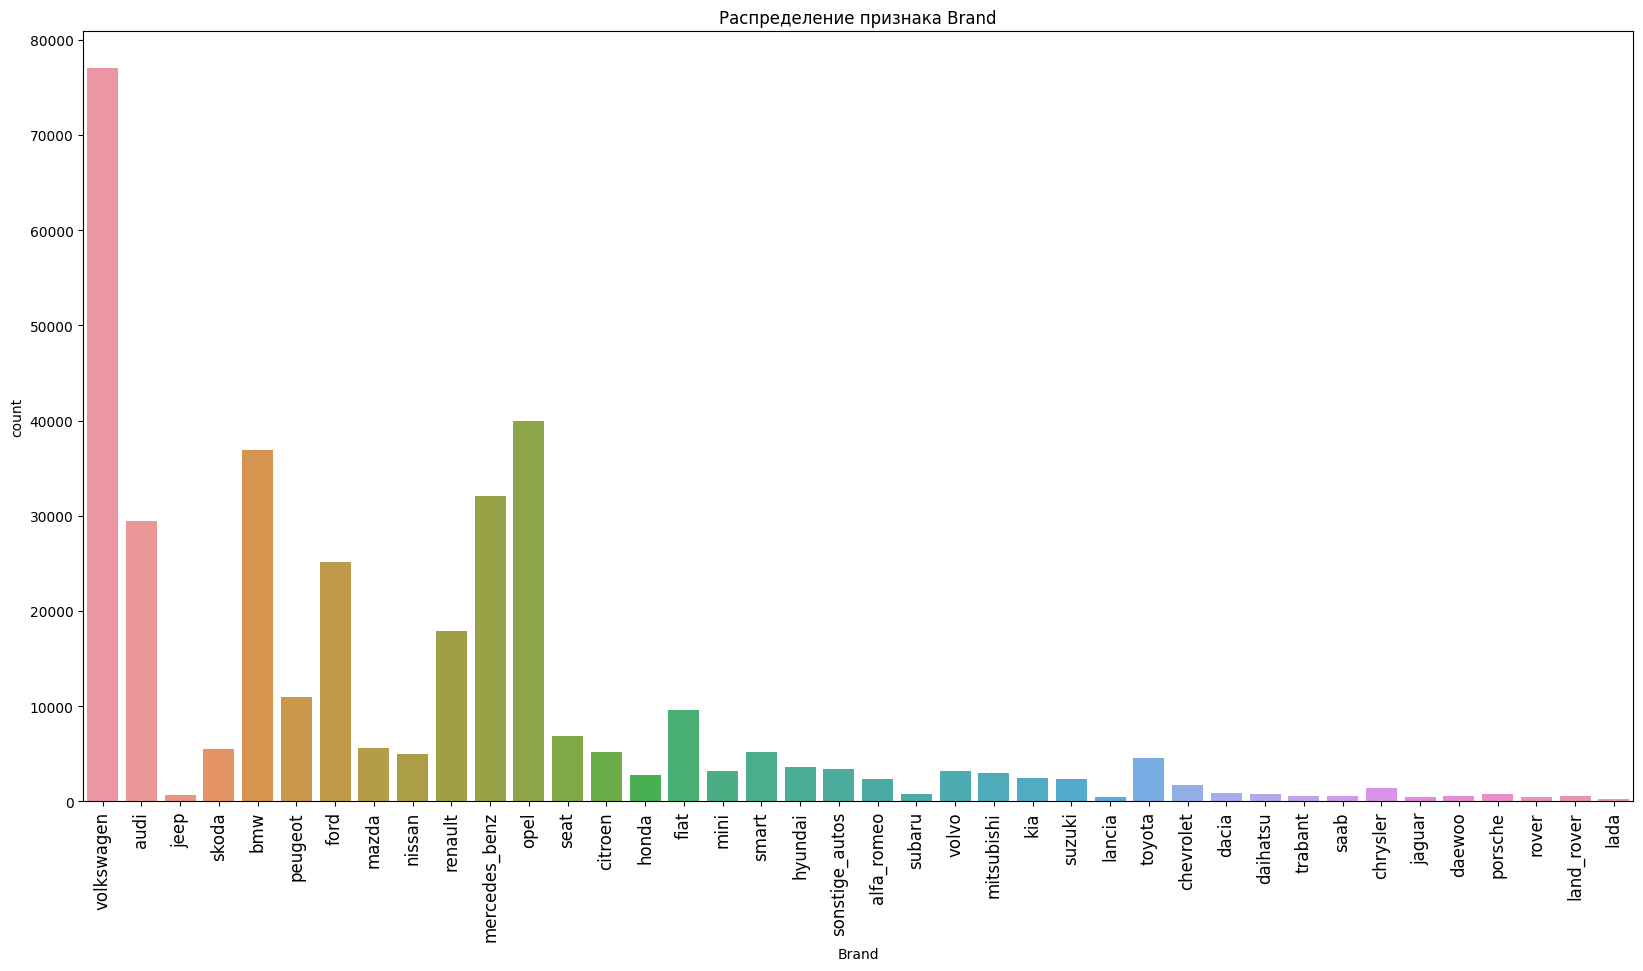

In [89]:
research_categorical_features(df, 'Brand')

В столбце нет пропусков. Предобработка не требуется

### Признак Model -  модель автомобиля

Анализ признака Model
+----------------------------------------------------------------------------------------------------+
Описательная статистика:


count     334664
unique       250
top         golf
freq       29232
Name: Model, dtype: object

+----------------------------------------------------------------------------------------------------+
Количество пропусков: 19705
Процент пропусков: 5.56%
+----------------------------------------------------------------------------------------------------+


C:\Users\Alexander\AppData\Local\Temp\ipykernel_12824\3896368005.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict= { 'fontsize': 12})


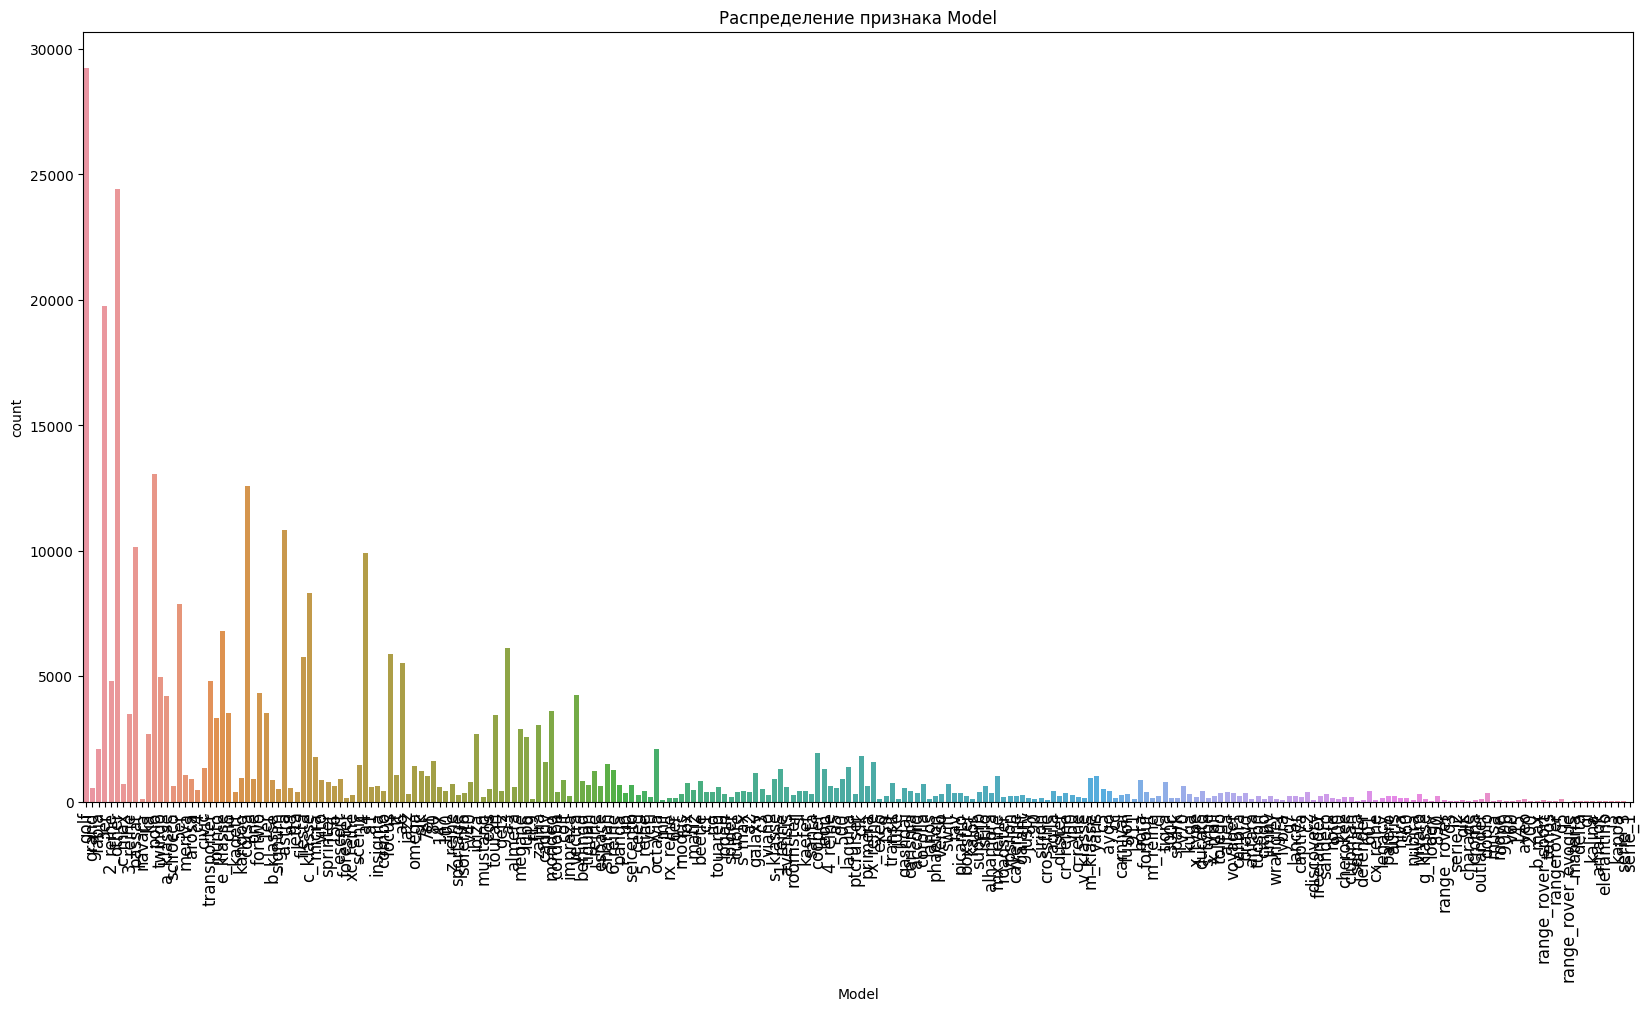

In [90]:
research_categorical_features(df, 'Model')

Данный признак содержит пропуски. Достоверно восстановить модель по имеющимся данным не возможно. Поэтому заполним пропуски значением `unknown`

In [91]:
df['Model'] = df['Model'].fillna('unknown')

In [92]:
df['Model'].isna().sum()

0

Пропусков в столбце не остлоась

### VehicleType — тип автомобильного кузова

Анализ признака VehicleType
+----------------------------------------------------------------------------------------------------+
Описательная статистика:


count     316879
unique         8
top        sedan
freq       91457
Name: VehicleType, dtype: object

+----------------------------------------------------------------------------------------------------+
Количество пропусков: 37490
Процент пропусков: 10.58%
+----------------------------------------------------------------------------------------------------+


C:\Users\Alexander\AppData\Local\Temp\ipykernel_12824\3896368005.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict= { 'fontsize': 12})


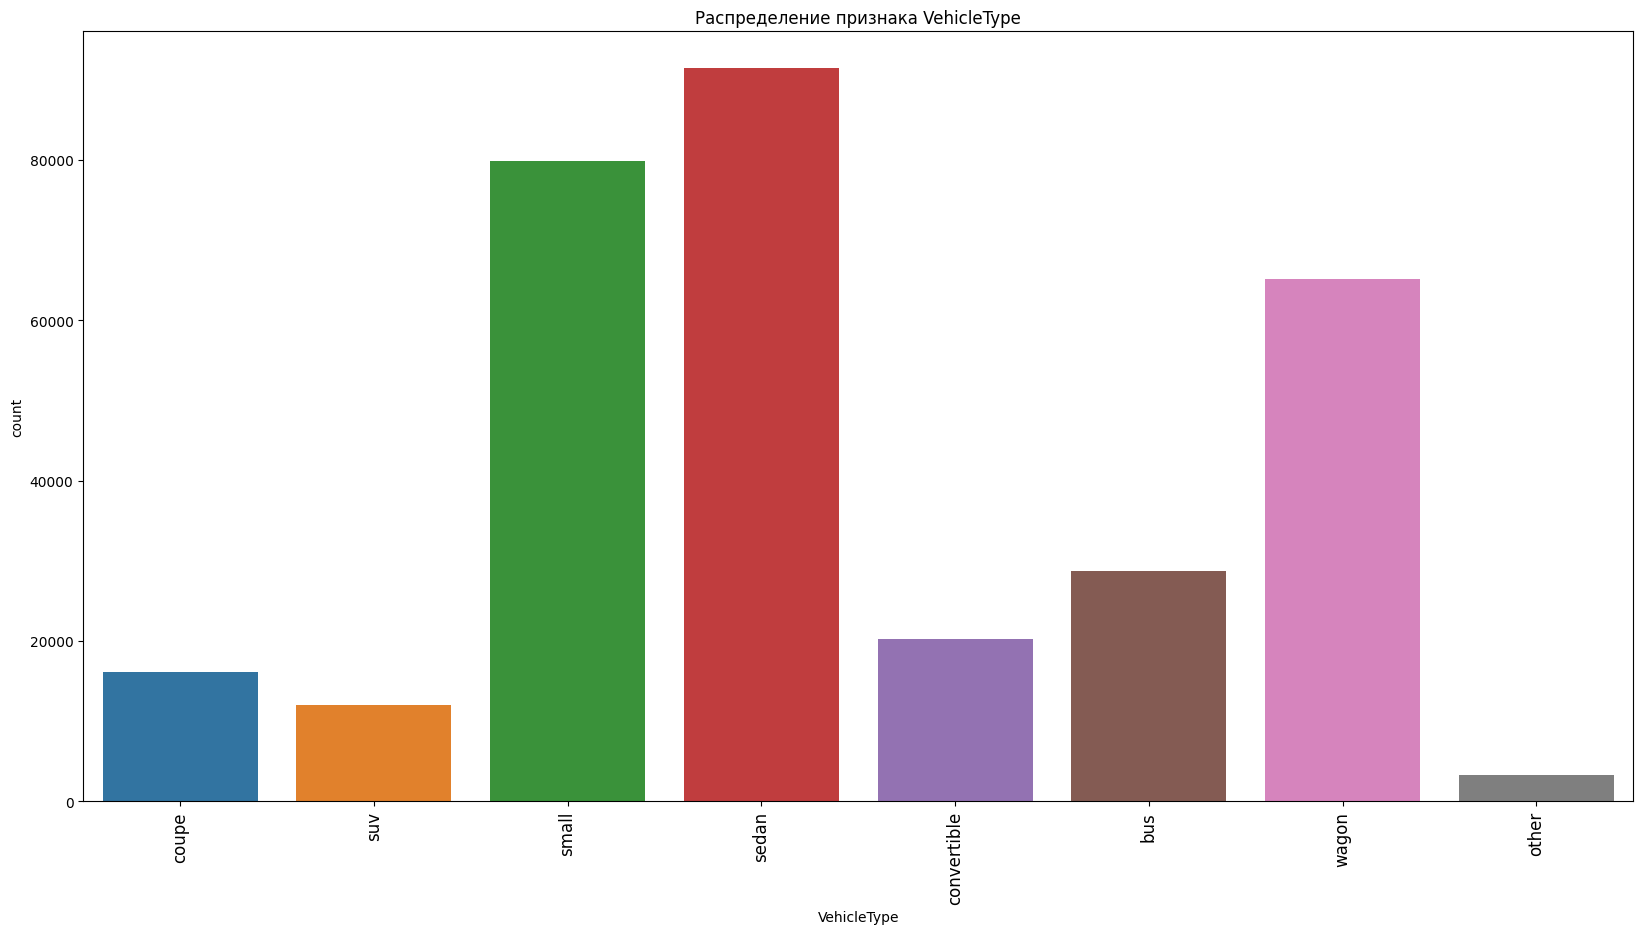

In [93]:
research_categorical_features(df, 'VehicleType')

В столбце `10.58%` значени пропущено. Слишком большой процент данных пропущен, чтобы удалять пропуски. Заполним пропуски следующим образом:
1. Сгруппируем данные по марке и модели.  
2. Посчитаем частоту, с которой встречаются типы кузовов в каждой группе.  
3. Выберем самый частовстречающийся тип кузова.

In [94]:
vehicle_type = (
    df
    .pivot_table(
        index=['Brand', 'Model'],
        values='VehicleType',
        aggfunc=lambda x: x.value_counts().index[0])
    )

In [95]:
def fix_vehicle_type(row, table_vehicle_type):
    return table_vehicle_type.loc[row['Brand'], row['Model']]

In [96]:
df.loc[df['VehicleType'].isna(), 'VehicleType'] = df.loc[
    df['VehicleType'].isna()
].apply(fix_vehicle_type, axis=1, table_vehicle_type=vehicle_type)

In [97]:
df['VehicleType'].isna().sum()

0

В столбце не осталось пропусков

### Признак Gearbox — тип коробки передач

Анализ признака Gearbox
+----------------------------------------------------------------------------------------------------+
Описательная статистика:


count     334536
unique         2
top       manual
freq      268251
Name: Gearbox, dtype: object

+----------------------------------------------------------------------------------------------------+
Количество пропусков: 19833
Процент пропусков: 5.60%
+----------------------------------------------------------------------------------------------------+


C:\Users\Alexander\AppData\Local\Temp\ipykernel_12824\3896368005.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict= { 'fontsize': 12})


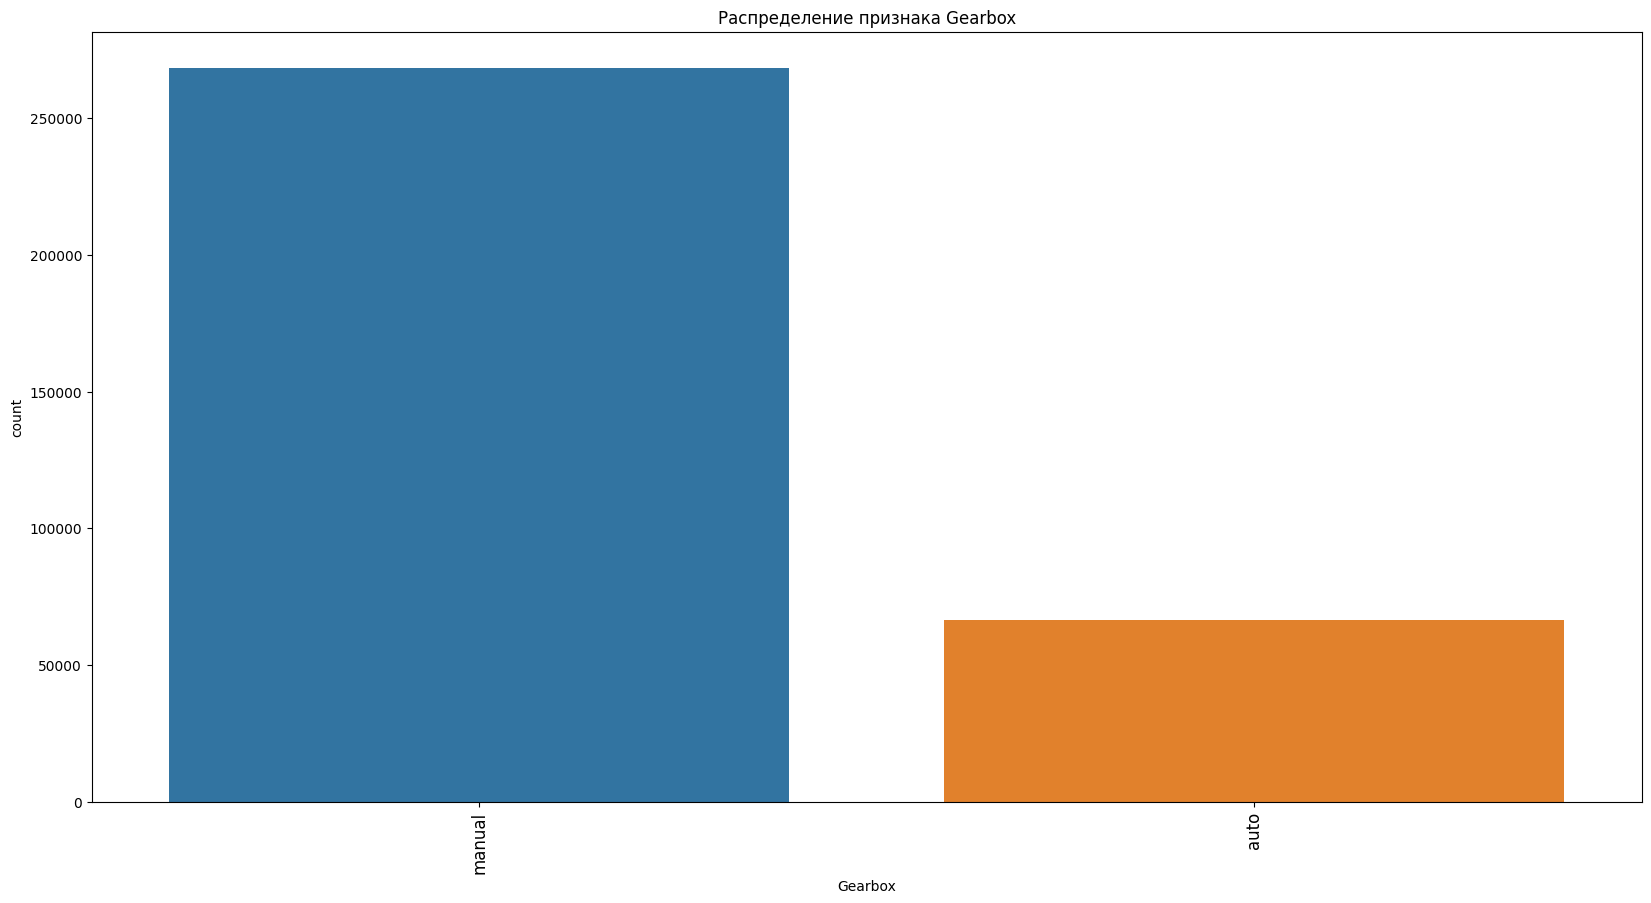

In [98]:
research_categorical_features(df, 'Gearbox')

В стобце `5.60%` пропусков. Восстановим пропуски по той же схеме, как делали со столбуом `VehicleType`

In [99]:
gearbox_type = (
    df
    .pivot_table(
        index=['Brand', 'Model'],
        values='Gearbox',
        aggfunc=lambda x: x.value_counts().index[0])
    )

In [100]:
def fix_gearbox(row, table_vehicle_type):
    return table_vehicle_type.loc[row['Brand'], row['Model']]

In [101]:
df.loc[df['Gearbox'].isna(), 'Gearbox'] = df.loc[
    df['Gearbox'].isna()
].apply(fix_gearbox, axis=1, table_vehicle_type=gearbox_type)

In [102]:
df['Gearbox'].isna().sum()

0

В столбце не осталось пропусков

Есть всего 2 типа коробки передач. Поэтому можно заменить значения в столбцах на 0 и 1:
* manual = 1
* auto = 0

In [103]:
df['Gearbox'] = df['Gearbox'].apply(lambda x: 1 if x == 'manual' else 0)

In [104]:
df['Gearbox'] = df['Gearbox'].astype('int32')

### Признак FuelType - тип топлива

Анализ признака FuelType
+----------------------------------------------------------------------------------------------------+
Описательная статистика:


count     321474
unique         7
top       petrol
freq      216352
Name: FuelType, dtype: object

+----------------------------------------------------------------------------------------------------+
Количество пропусков: 32895
Процент пропусков: 9.28%
+----------------------------------------------------------------------------------------------------+


C:\Users\Alexander\AppData\Local\Temp\ipykernel_12824\3896368005.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict= { 'fontsize': 12})


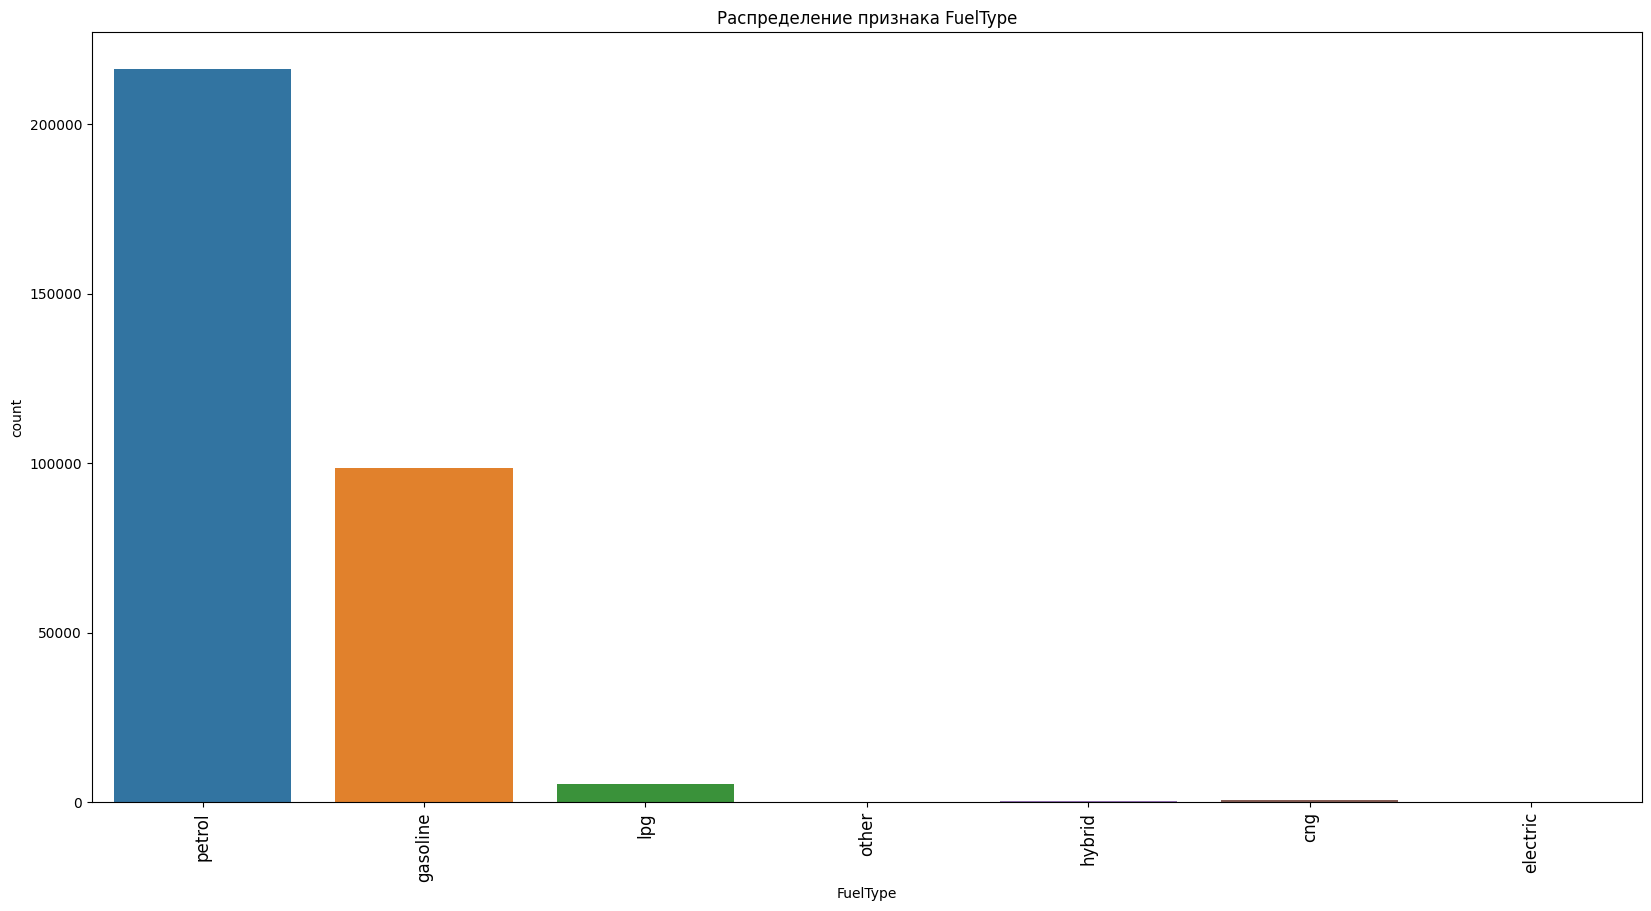

In [105]:
research_categorical_features(df, 'FuelType')

В столбце `9.28%` процентов пропусков. В столбце сильно преобладает значение `petrol`. Заполним пропуски этим значением

In [106]:
df.fillna({'FuelType': 'petrol'}, inplace=True)

In [107]:
df['FuelType'].isna().sum()

0

В столбце не осталось пропусков

### Признак Repaired — была машина в ремонте или нет

Анализ признака Repaired
+----------------------------------------------------------------------------------------------------+
Описательная статистика:


count     283215
unique         2
top           no
freq      247161
Name: Repaired, dtype: object

+----------------------------------------------------------------------------------------------------+
Количество пропусков: 71154
Процент пропусков: 20.08%
+----------------------------------------------------------------------------------------------------+


C:\Users\Alexander\AppData\Local\Temp\ipykernel_12824\3896368005.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict= { 'fontsize': 12})


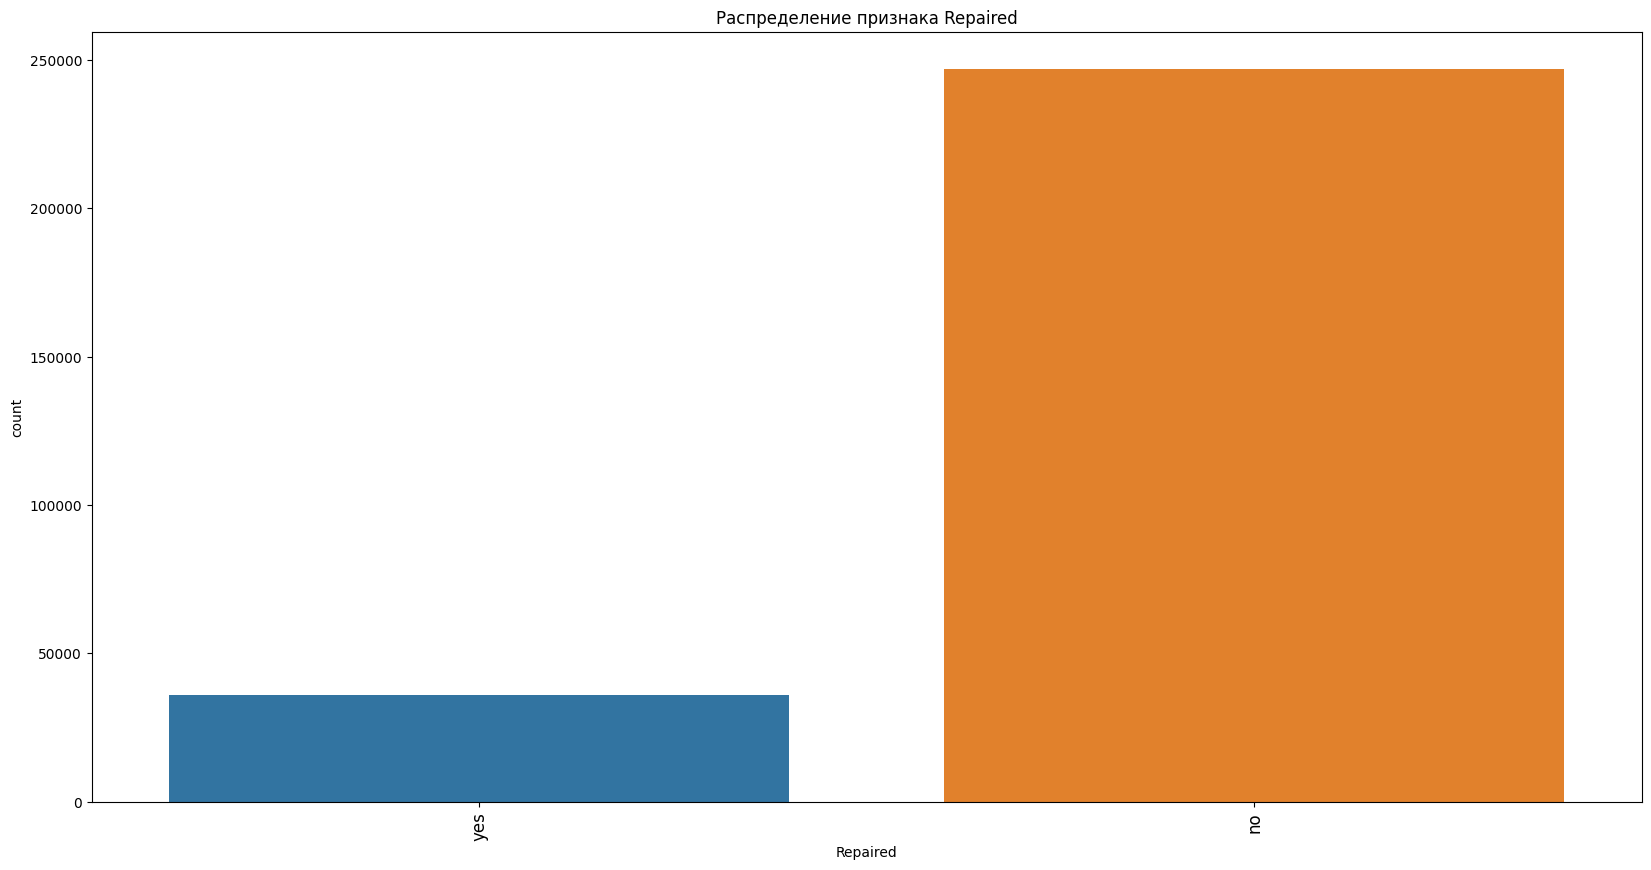

In [108]:
research_categorical_features(df, 'Repaired')

Признак содержит `18.25%` пропусков. Удалять такое количество данных нельзя. Заполним пропуски значением no, так как:
1. Данное значение преобладает в столбце  
2. Если автомобиль не был в ремонте, то человек, скорее всего, просто не заполнял это поле

In [109]:
df.fillna({'Repaired': 'no'}, inplace=True)

In [110]:
df['Repaired'].isna().sum()

0

В столбце не осталось пропусков

Признак содержит только 2 значение. Поэтому можно заменить значения в столбцах на 0 и 1:
* yes = 1
* no = 0

In [111]:
df['Repaired'] = df['Repaired'].apply(lambda x: 1 if x == 'yes' else 0)

In [112]:
df['Repaired'] = df['Repaired'].astype('int32')

<div class="alert alert-block alert-success">
<b>Успех:</b>  Пропуски обработаны хорошим образом
</div>


<div class="alert alert-block alert-info">
<b>Совет:</b> У fuel_type есть категории, которые означают одно и тоже - их можно объединить, либо подумать может они действительно означают, что-то разное.
</div>



### Признак RegistrationYear - год регистрации автомобиля 

Анализ признака RegistrationYear
+----------------------------------------------------------------------------------------------------+
Описательная статистика:


count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

+----------------------------------------------------------------------------------------------------+
Количество пропусков: 0
Процент пропусков: 0.00%
+----------------------------------------------------------------------------------------------------+


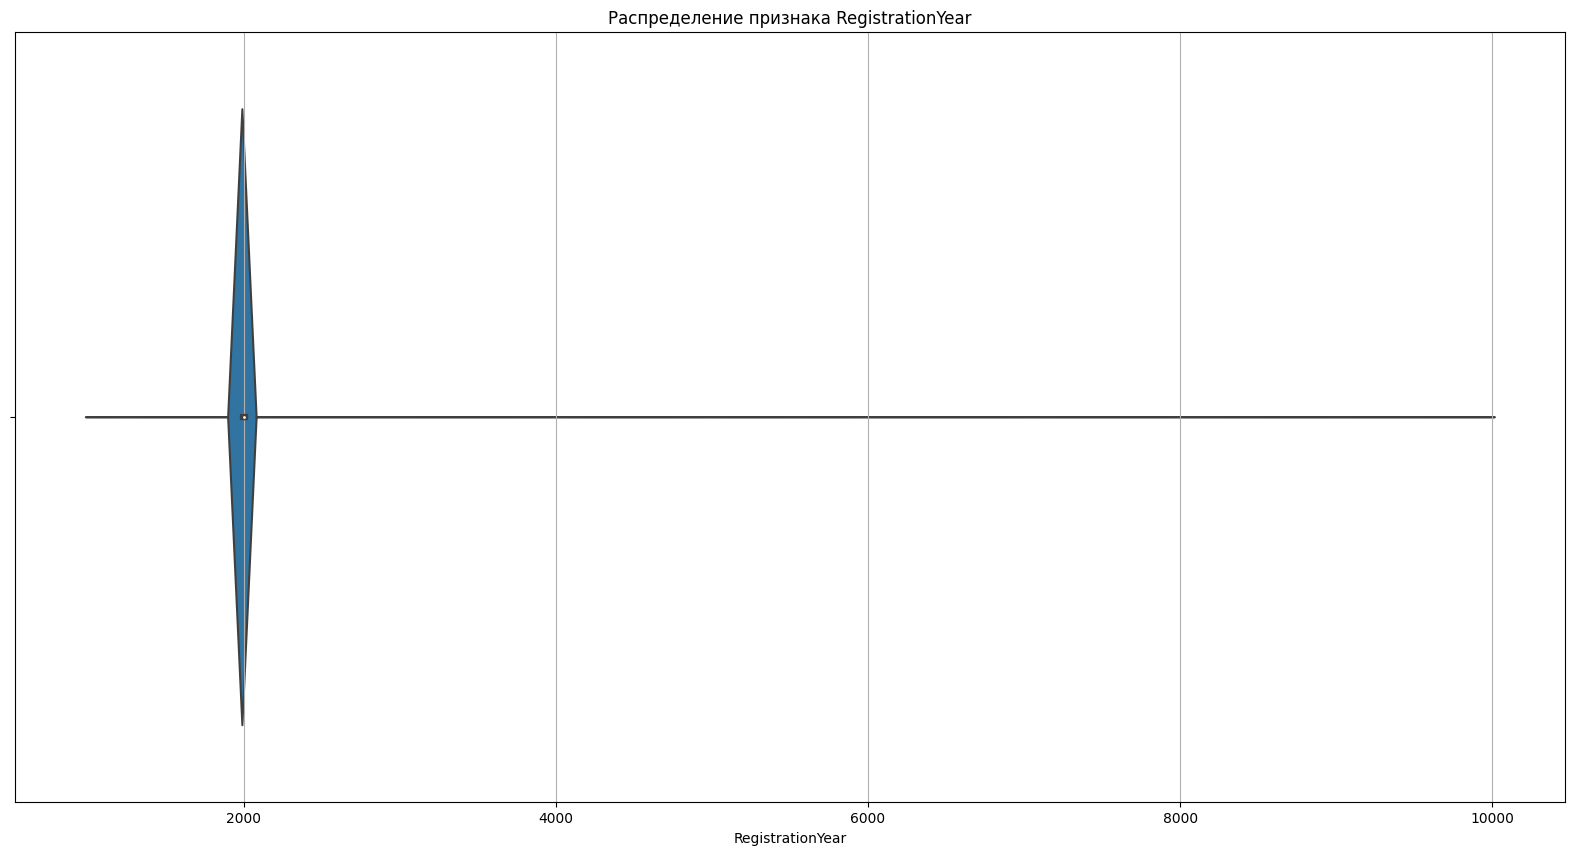

In [113]:
research_numerical_feature(df, 'RegistrationYear')

Признак не имеет пропусков. Однако содержит аномальные значения:  
* Минимальный год регистрации - 1000  
* Максимальный год регистрации - 9999  

In [114]:
df['DateCreated'] = pd.to_datetime(
    df['DateCreated'], format='%Y-%m-%d'
)
max_year_created = df['DateCreated'].dt.year.max()
print(f'Самый поздний год регистрации анкеты: {max_year_created}')

Самый поздний год регистрации анкеты: 2016


Исключим из датасета анкеты, имеющие год регистрации до 1950 и после 2016

In [115]:
df = df.query('1950 <= RegistrationYear <= 2016')



<div class="alert alert-block alert-success">
<b>Успех:</b> С границами согласен
</div>


In [116]:
print(f'В датасете осталось {df.shape[0] / START_DATA_SIZE:.2%} данных')

В датасете осталось 95.83% данных


Вместо данного признака будем использовать признак - возраст автомобиля (год создания анкеты - год регистрации автомобиля )

In [117]:
df['age'] = df['DateCreated'].dt.year - df['RegistrationYear']


<div class="alert alert-block alert-info">
<b>Совет:</b> У нас разный возраст машин. Есть гипотеза, что для разных возрастов - своё ценообразование. Поэтому, можно попробовать ввести фактор "тип возраста" (ретро, супер-ретро, старая, новая... надо подумать..)..<br>

</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Интересная теория. Но думаю, что внесение таких признаков требует консультации с экспертами по автомобилям
</div>

### Power — мощность (л. с.)

Анализ признака Power
+----------------------------------------------------------------------------------------------------+
Описательная статистика:


count    339593.000000
mean        111.045696
std         186.899948
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

+----------------------------------------------------------------------------------------------------+
Количество пропусков: 0
Процент пропусков: 0.00%
+----------------------------------------------------------------------------------------------------+


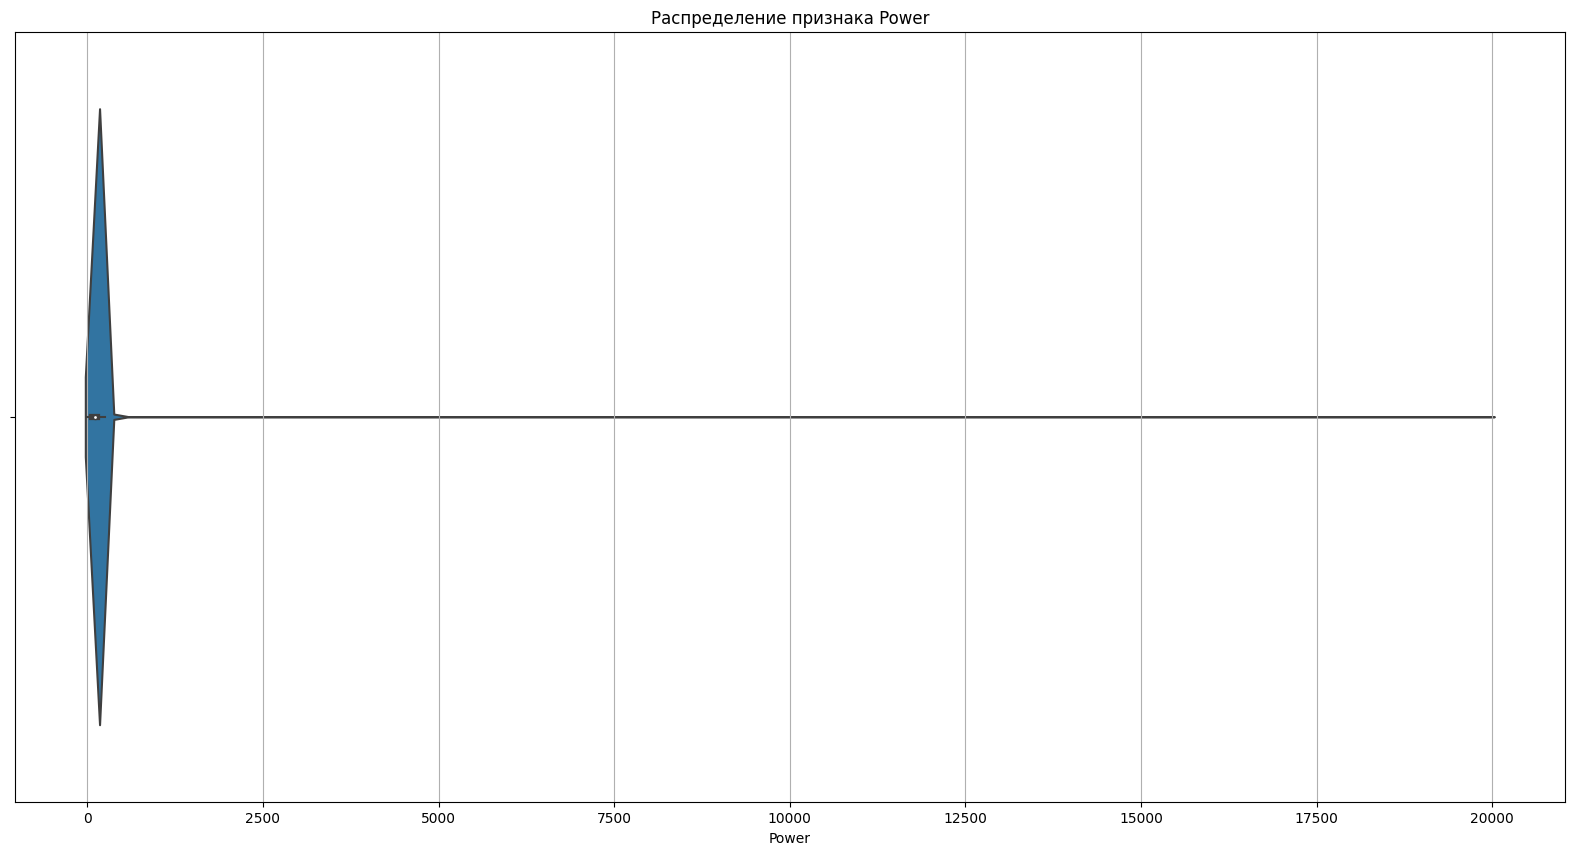

In [118]:
research_numerical_feature(df, 'Power')

Признак не имеет пропусков, однако содержит аномальные значения:
* Есть строки со значением 0  
* Максимальное значение, которое содержит признак 20000, что привышает разумные пределы  
  
В интернете удалось найти следующие данные:
* Самый мощный найденный автомобиль - Dagger GT(2028 л.с.). Поэтому оставим только анкеты, у которых можность двигателя меньше 2000 л.с.  
* Самый маломащный найденный автомобиль - СеАЗ СМЗ С-3А (8 л.с). Автомобиль выпускался с 1958 по 1970 гг, что подходит под наши ограничения по году регистраии. Оставим только анкеты, у которыз мощность двигателя больше 10 л.с.  
  
Помимо удаления аномальных значений данного признака можно попробовать заменить их на медиану мощности по модели или марке автомобиля

In [119]:
count_anomaly_power = df.query('Power < 10 or Power > 2000')['Power'].count()
print(f'Количество аномальных значений в столбце Power: {count_anomaly_power}')

Количество аномальных значений в столбце Power: 36649



<div class="alert alert-block alert-info">
<b>Совет:</b>  Вопрос на подумать: Как думаешь а машины с 0-ой мощностью могут быть просто без двигателя?
</div>


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Тоже интересная теория. Однако не будет ли это сбивать модель?
</div>

Аномальные значения составляют примерно 10% датасета. Это очень много, чтобы удалять. Для начала попробуем заменить на медиану по марке автомобиле. При этом, если значение марки будет `unknown`, то будем заменять на среднее значение по марке автомобиля

In [120]:
df.loc[
    (df['Power'] < 10) |
    (df['Power'] > 2000) &
    (df['Model'] == 'unknown'),
    'Power'
] = df.groupby('Brand')['Power'].transform('median')

In [121]:
df.loc[
    (df['Power'] < 10) |
    (df['Power'] > 2000) &
    (df['Model'] != 'unknown'),
    'Power'
] = df.groupby('Model')['Power'].transform('median')

In [122]:
df.query('10 < Power < 2000')['Power'].count()

339578

Аномальные значения в столбце исключены

### Признак Kilometer

Анализ признака Kilometer
+----------------------------------------------------------------------------------------------------+
Описательная статистика:


count    339593.000000
mean     128123.960152
std       37842.413937
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

+----------------------------------------------------------------------------------------------------+
Количество пропусков: 0
Процент пропусков: 0.00%
+----------------------------------------------------------------------------------------------------+


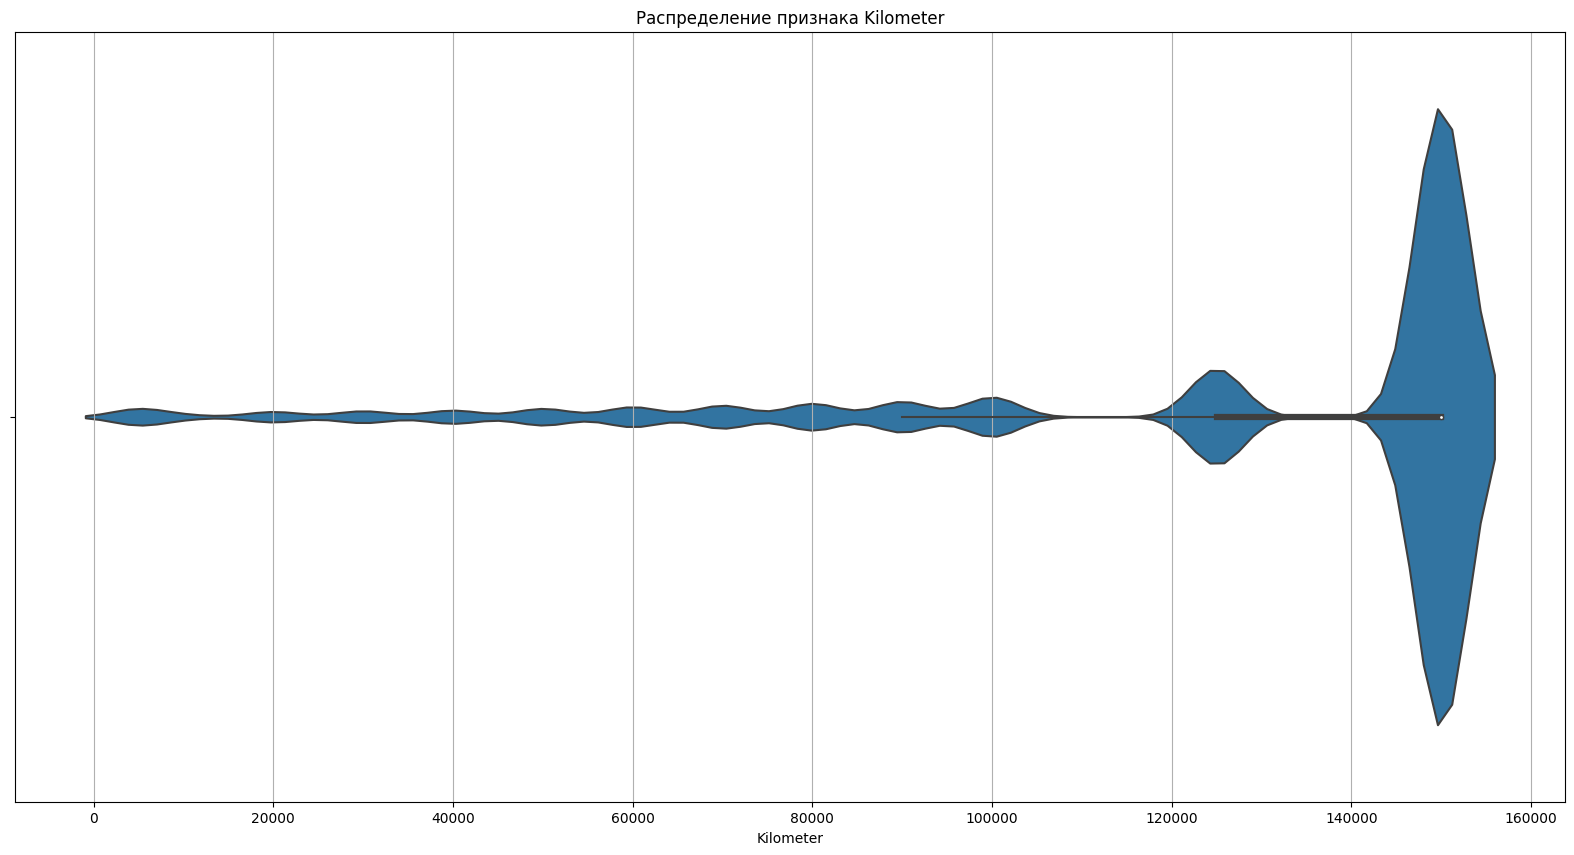

In [123]:
research_numerical_feature(df, 'Kilometer')

В столбце нет пропусков. Также первый взгяд в столбце не аномалий. Однако стоит заметить, что значение 2, 3 квантилей и максимальное значение равны между собой. Следовательно, минимум половина датасета содержит в данном столбце значение 150000. Это достаточно странно и стоило бы уточнить данный момент.

### Признак NumberOfPictures

Анализ признака NumberOfPictures
+----------------------------------------------------------------------------------------------------+
Описательная статистика:


count    339593.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

+----------------------------------------------------------------------------------------------------+
Количество пропусков: 0
Процент пропусков: 0.00%
+----------------------------------------------------------------------------------------------------+


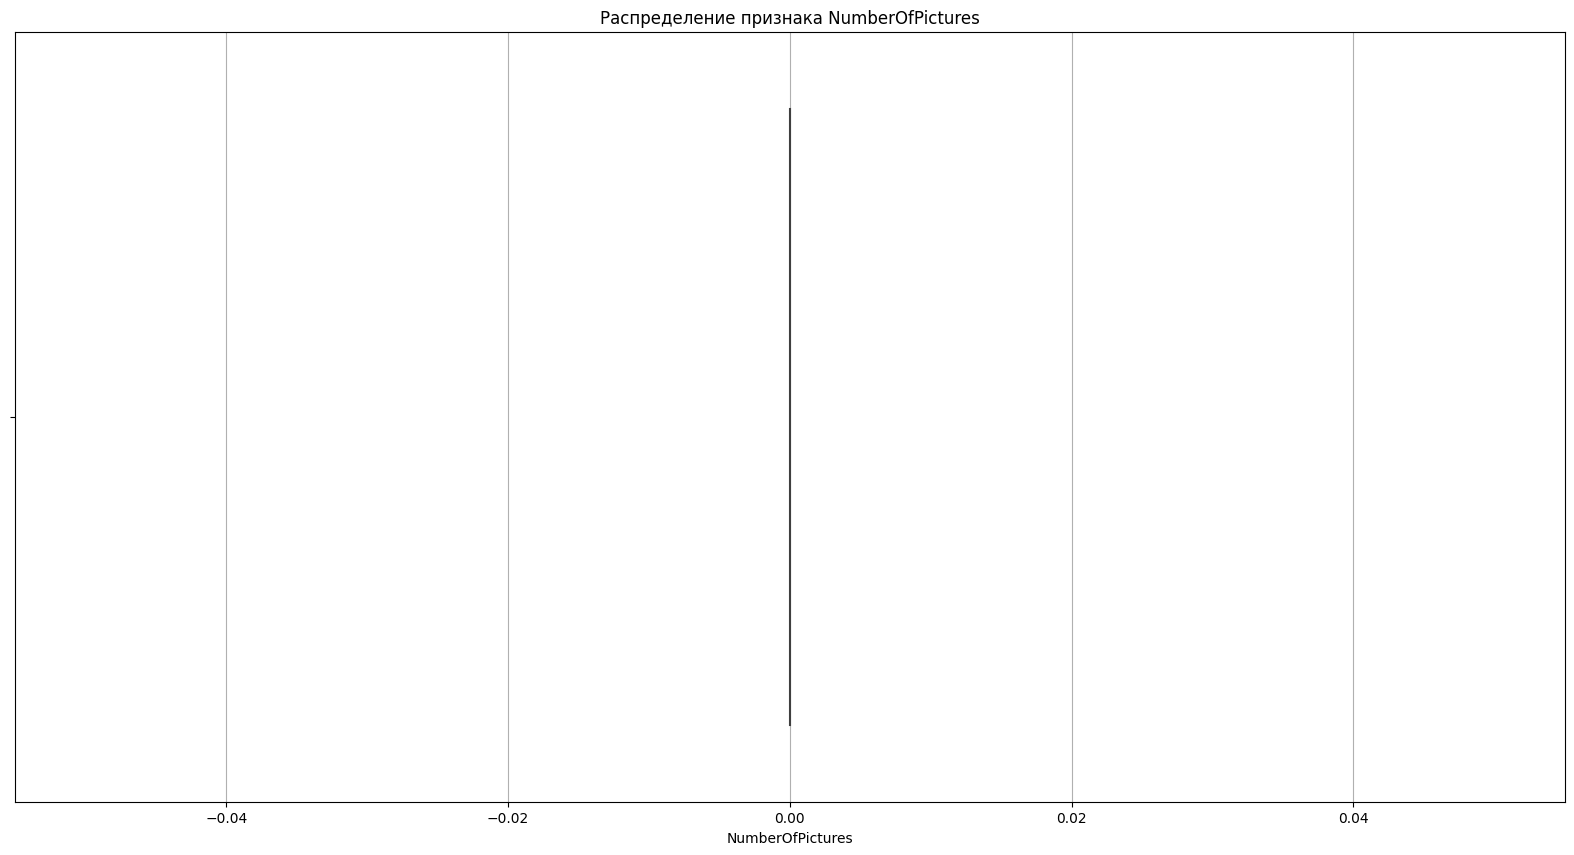

In [124]:
research_numerical_feature(df, 'NumberOfPictures')

В столбце все значения равно 0. Поэтому данный признак совершенно бесполезен и использовать его нет смысла

### Целевой признак Price — цена (евро)

Анализ признака Price
+----------------------------------------------------------------------------------------------------+
Описательная статистика:


count    339593.000000
mean       4471.566207
std        4545.245169
min           0.000000
25%        1100.000000
50%        2799.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

+----------------------------------------------------------------------------------------------------+
Количество пропусков: 0
Процент пропусков: 0.00%
+----------------------------------------------------------------------------------------------------+


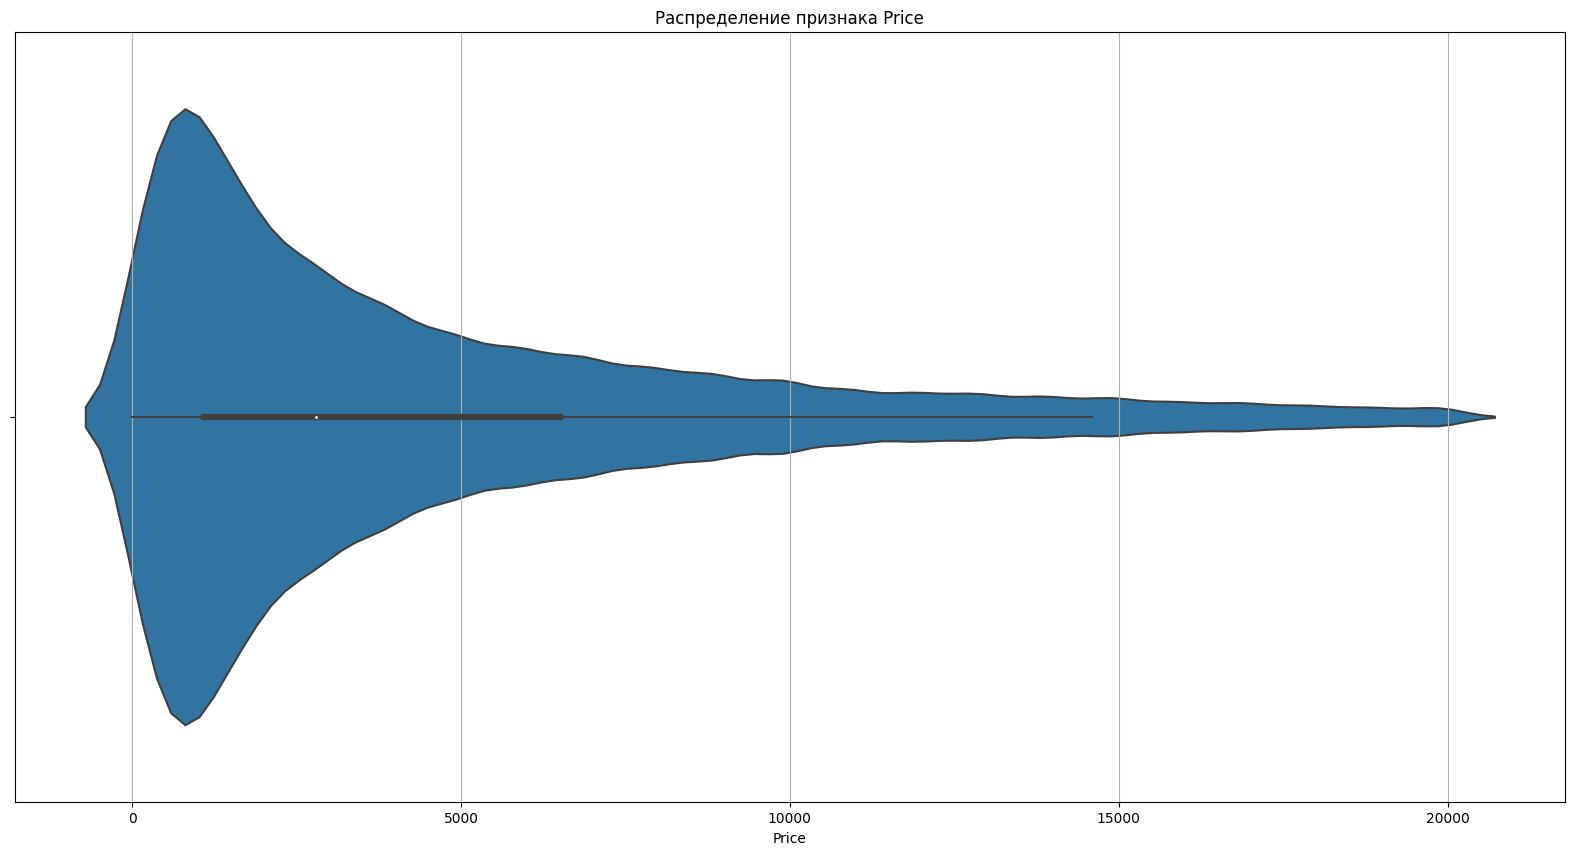

In [125]:
research_numerical_feature(df, 'Price')

Можно заметить, что минимальное значение признака равно 0, не соответствует реалиям. Также по графику видно, что признак имеет длинный правых хвост. Оставим только данные, которые лежат правее 5 перцентили

<div class="alert alert-block alert-success">
<b>Успех:</b> Самое интересное, что на нескольких сайтов по продажам подержанных автомобилей в Германии (страну можно определить по почтовым индексам, большинство из них из Германии) показало, что цены начинаются действительно с 0 и 1 евро, но это единичные объявления и не понятно, то ли это ошибка при заполнении формы, то ли машины на металлолом. Но я  все-таки склоняюсь к тому, чтобы избавиться от таких данных
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Не согласен с удалением данных, используя верхнюю границу. Разве цены на машины в 15,20 тысяч евро являются неадекватными? Это ценные наблюдения, которые мы можем потерять
</div>


<div class="alert alert-block alert-warning">
<b>Изменения:</b> исправил
</div>

In [126]:
q_05 = df['Price'].quantile(.05)
df = df.query('@q_05 < Price')

### Удаление дубликатов

In [127]:
df.duplicated().sum()

5

In [128]:
df.drop_duplicates(inplace=True)

In [129]:
print(f'После предобработки данных в датасете осталось {df.shape[0] / START_DATA_SIZE:.2%} данных')

После предобработки данных в датасете осталось 90.64% данных



<div class="alert alert-block alert-success">
<b>Успех:</b> А так в целом хорошая, детальная предобработка - идем дальше
</div>

<div class="alert alert-block alert-info">
<b>Совет:</b> 

 Советую обратить внимание на библиотеки sweetviz и pandas_profiling помогут в проведении более тщательного EDA анализа. Исследовательский анализ можно делать и с помощью ручного вызова функций дефолтных библиотек. Данные библиотеки хороши для максимизации комфорта презентации результатов анализа бизнес-пользователям. 
    
Очень просты в использоовании, на вход кладется датафрейм: pandas_profiling.ProfileReport(df) 
</div>


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Спасибо за наводку. Про pandas_profiling слышал. Однако решил, что мои уже давно написанные функции очень похожи на то, что делает эта библиотека. А вот sweetviz изучу подробнее
</div>

## Обучение моделей

### Подготовка признаков

Для обучения буду использоваться следующие признаки:
1. Количественные:
    * Power — мощность (л. с.)  
    * Kilometer — пробег (км)  
    * age - возраст автомобиля  
2. Категориальные:
    * VehicleType — тип автомобильного кузова  
    * Model — модель автомобиля  
    * FuelType — тип топлива  
    * Brand — марка автомобиля  
3. Булевы:
    * Gearbox — тип коробки передач (1 - manual(ручная коробка передач))
    * Repaired — была машина в ремонте или нет (1 - была в ремонте)  

In [130]:
features_numerical = ['Power', 'Kilometer', 'age']
features_categorical = ['Model', 'Brand', 'VehicleType', 'FuelType']
features_bool = ['Gearbox', 'Repaired']
target_column = ['Price']
columns_all = features_numerical + features_categorical + features_bool + target_column

In [131]:
df = df[columns_all]

Для анализа будут использоваться следующие модели:  
1. LinearRegression
2. CatBoostRegressor  
3. LGBMRegressor  
  
Так как CatBoostRegressor и LGBMRegressor могут работать с категориальными признаками сами, то подготовим 2 набора данных: с кодированием категориальных признаков и без

In [132]:
features = df.drop('Price', axis=1)
target = df['Price']

In [133]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.2, random_state=RANROM_STATE
)

In [134]:
scaler = StandardScaler().fit(features_train[features_numerical])
features_train[features_numerical] = scaler.transform(features_train[features_numerical])
features_test[features_numerical] = scaler.transform(features_test[features_numerical])

C:\Users\Alexander\AppData\Local\Temp\ipykernel_12824\1213871706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[features_numerical] = scaler.transform(features_train[features_numerical])
c:\Data\practicum\data_science\price_auto\venv\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\Alexander\AppData\Local\Temp\ipykernel_12824\1213871706.py:3: SettingWithCopyWarning: 
A value i


<div class="alert alert-block alert-success">
<b>Успех:</b> Масштабирование применено корректно

In [135]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

In [136]:
encoder = OneHotEncoder(handle_unknown='ignore', dtype='int').fit(features_train_ohe[features_categorical])

In [137]:
features_train_ohe = ohe(features_train_ohe, encoder, features_categorical)
features_test_ohe = ohe(features_test_ohe, encoder, features_categorical)


<div class="alert alert-block alert-danger">
    
<b>Ошибка:</b> Важно указывать параметр `drop='first'`, иначе попадаем в dummy-ловушку.  https://www.codecamp.ru/blog/dummy-variable-trap/

Если возникает конфликт параметров, то нужно перед импортами обновить пакет до подходящий версии. `!pip install scikit-learn==1.1.3` 

</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Исправил для части признаков. Однако для признаков марка и модель считаю, что лучше оставить энкодер с игнорирование неизвестных значений. Так как в тестовой выборке нам может прийти значение, которое просто не попало в тренировочную и все сломается...
</div>

Для тестирования моделей LightGBMRegressor и CatBoostRegressor без преобразования категориальных признаков изменим тип колонок с категориальными признаками на `caterogy` (без этого модели не захотели работать)

In [138]:
features_train[features_categorical] = features_train[features_categorical].astype('category')
features_test[features_categorical] = features_test[features_categorical].astype('category')

c:\Data\practicum\data_science\price_auto\venv\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [139]:
features_train.info()
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256967 entries, 293063 to 134498
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Power        256967 non-null  float64 
 1   Kilometer    256967 non-null  float64 
 2   age          256967 non-null  float64 
 3   Model        256967 non-null  category
 4   Brand        256967 non-null  category
 5   VehicleType  256967 non-null  category
 6   FuelType     256967 non-null  category
 7   Gearbox      256967 non-null  int32   
 8   Repaired     256967 non-null  int32   
dtypes: category(4), float64(3), int32(2)
memory usage: 19.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64242 entries, 160409 to 352743
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Power        64242 non-null  float64 
 1   Kilometer    64242 non-null  float64 
 2   age          64242 non-null  float64 
 3   Mod

#### Проверям скорость обучения и придсказания

### Модель LinearRegression

#### Проверяем качество модели

In [140]:
linear_model = LinearRegression(n_jobs=-1)

In [141]:
%%time
results_linear_model = cross_validate(
    linear_model,
    features_train_ohe,
    target_train,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

CPU times: total: 1min 56s
Wall time: 13.6 s


In [142]:
results_linear_model

{'fit_time': array([2.68695927, 2.63338971, 2.66242194, 2.68235421, 2.68445754]),
 'score_time': array([0.04330945, 0.0440402 , 0.04504108, 0.04403973, 0.04404044]),
 'test_score': array([-1.03808706e+12, -7.12433087e+11, -2.80246880e+03, -2.81573016e+03,
        -2.81283806e+03])}

In [143]:
rmse_linear_model = -1 * results_linear_model["test_score"].mean()
print(f'RMSE = {rmse_linear_model}')

RMSE = 350104030983.50916


По результатам модели на кросс-валидации видно, что модель линейной регрессии нестабильная. На некоторых выборках она дает очень большую ошибку

#### Проверям скорость обучения и предсказания

In [144]:
linear_model = LinearRegression(n_jobs=-1)

In [145]:
%%time
linear_model.fit(features_train_ohe, target_train)

CPU times: total: 30.7 s
Wall time: 3.34 s


LinearRegression(n_jobs=-1)

Для предсказания используем тренировочную выборку, так как сейчас нам не важно качество модели. Цель - изучить время работы модели

In [146]:
%%time
predicted = linear_model.predict(features_train_ohe)

CPU times: total: 672 ms
Wall time: 212 ms


Обучение модели занимает `26 с`, предсказание занимает `0.45 c`

### Модель LightGBMRegressor

#### Проверяем качество модели

In [147]:
gscv_lgbm_regressor_config = {
    'num_leaves': [50, 100, 200],
    'learning_rate': [.1, .3, .5],
    'max_depth': [-1, 1, 2, 3, 4, 5],
    'n_estimators': range(50, 301, 50)
}

##### Использование признаков с OHE

##### Проверяем качество модели

In [148]:
model_lgbm_regressor = LGBMRegressor(n_jobs=-1, random_state=RANROM_STATE) 

In [149]:
%%time
result_lgbm_regressor = research_model(
    model_lgbm_regressor, gscv_lgbm_regressor_config, features_train_ohe, target_train
)

CPU times: total: 15.2 s
Wall time: 26min 9s


In [150]:
pd.set_option('display.max_colwidth', None)
result_lgbm_regressor[['params', 'mean_train_score', 'mean_test_score']].head(3)

,params,mean_train_score,mean_test_score
17,"{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 200}",-1339.658911,-1559.241860
14,"{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 250, 'num_leaves': 200}",-1362.380410,-1563.378322
11,"{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 200}",-1389.706552,-1569.412672


params	mean_train_score	mean_test_score  
17	{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 200}	-1144.966729	-1312.656374  
14	{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 250, 'num_leaves': 200}	-1163.664050	-1315.498704  
11	{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 200}	-1185.001529	-1319.879796  

In [151]:
print(f'Модель с лучшем качеством имеет параметры - {result_lgbm_regressor.loc[17, "params"]}')

Модель с лучшем качеством имеет параметры - {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 200}


In [152]:
rmse_lgbm_regressor = -1 * result_lgbm_regressor.loc[17, "mean_test_score"]
print(f'Качество лучшей модели: RMSE = {rmse_lgbm_regressor}')

Качество лучшей модели: RMSE = 1559.2418599625512


##### Проверям скорость обучения и предсказания

In [153]:
model_lgbm_regressor = LGBMRegressor(
    n_jobs=-1,
    random_state=RANROM_STATE,
    learning_rate=.1,
    max_depth=-1,
    n_estimators=300,
    num_leaves=200
)

In [154]:
%%time
model_lgbm_regressor.fit(features_train_ohe, target_train)
!

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 256967, number of used features: 294
[LightGBM] [Info] Start training from score 4719.405803
CPU times: total: 31.7 s
Wall time: 2.69 s


Для предсказания используем тренировочную выборку, так как сейчас нам не важно качество модели. Цель - изучить время работы модели

In [155]:
%%time
predicted = model_lgbm_regressor.predict(features_train_ohe)

CPU times: total: 13 s
Wall time: 1.02 s


Обучение модели занимает `27.2 c`, предсказание занимает `12.1 c`

##### Использование признаков без кодирования OHE

##### Проверяем качество модели

In [156]:
fit_params = {'categorical_feature': features_categorical}

In [157]:
%%time
result_lgbm_regressor_without_ohe = research_model(
    model_lgbm_regressor, gscv_lgbm_regressor_config, features_train, target_train, 5, fit_params
)

CPU times: total: 19 s
Wall time: 13min 30s


In [158]:
result_lgbm_regressor_without_ohe[['params', 'mean_train_score', 'mean_test_score']].head(3)

,params,mean_train_score,mean_test_score
17,"{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 200}",-1290.613773,-1547.892553
14,"{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 250, 'num_leaves': 200}",-1310.636748,-1550.561867
11,"{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 200}",-1334.127861,-1553.804425


params	mean_train_score	mean_test_score  
17	{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 200}	-1111.151785	-1304.802934  
14	{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 250, 'num_leaves': 200}	-1126.433403	-1306.787713  
11	{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 200}	-1144.571583	-1309.673676  

In [159]:
print(f'Модель с лучшем качеством имеет параметры - {result_lgbm_regressor_without_ohe.loc[17, "params"]}')

Модель с лучшем качеством имеет параметры - {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 200}


In [160]:
rmse_lgbm_regressor_without_ohe = -1 * result_lgbm_regressor_without_ohe.loc[17, "mean_test_score"]
print(f'Качество лучшей модели: RMSE = {rmse_lgbm_regressor_without_ohe}')

Качество лучшей модели: RMSE = 1547.892553065981


##### Проверям скорость обучения и предсказания

In [161]:
model_lgbm_regressor_without_ohe = LGBMRegressor(
    n_jobs=-1,
    random_state=RANROM_STATE,
    learning_rate=.1,
    max_depth=-1,
    n_estimators=300,
    num_leaves=200
)

In [162]:
%%time
model_lgbm_regressor_without_ohe.fit(features_train, target_train, categorical_feature=features_categorical)
!

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 256967, number of used features: 9
[LightGBM] [Info] Start training from score 4719.405803
CPU times: total: 26.1 s
Wall time: 1.97 s


Для предсказания используем тренировочную выборку, так как сейчас нам не важно качество модели. Цель - изучить время работы модели

In [165]:
%%time
predicted = model_lgbm_regressor_without_ohe.predict(features_train)

CPU times: total: 10.3 s
Wall time: 736 ms


Обучение модели занимает `24 c`, предсказание занимает `12.1 c`

### Модель CatBoostRegressor

In [166]:
gscv_cat_boost_regressor_config = {
    'learning_rate':[.1, .5, .8],
    'max_depth': range(1, 6),
    'n_estimators': range(50, 401, 50)
}

#### Использование признаков с OHE

##### Проверяем качество модели

In [167]:
model_cat_boost_regressor = CatBoostRegressor(random_state=RANDOM_STATE_FOR_CAT_BOOST, verbose=False)

In [168]:
%%time
result_cat_boost_regressor_config = research_model(
    model_cat_boost_regressor, gscv_cat_boost_regressor_config, features_train_ohe, target_train
)

KeyboardInterrupt: 

In [ ]:
result_cat_boost_regressor_config[['params', 'mean_train_score', 'mean_test_score']].head(3)

params	mean_train_score	mean_test_score  
119	{'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 400}	-1278.753542	-1365.457625  
79	{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 400}	-1305.508150	-1367.887442  
118	{'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 350}	-1290.513183	-1368.972890  

In [ ]:
print(f'Модель с лучшем качеством имеет параметры - {result_cat_boost_regressor_config.loc[119, "params"]}')

In [ ]:
rmse_cat_boost_regressor = -1 * result_cat_boost_regressor_config.loc[119, "mean_test_score"]
print(f'Качество лучшей модели: RMSE = {rmse_cat_boost_regressor}')

##### Проверям скорость обучения и предсказания

In [ ]:
model_cat_boost_regressor = CatBoostRegressor(
    random_state=RANDOM_STATE_FOR_CAT_BOOST,
    verbose=False, 
    learning_rate=.8,
    max_depth=5,
    n_estimators=400,
)

In [ ]:
%%time
model_cat_boost_regressor.fit(features_train_ohe, target_train)

Для предсказания используем тренировочную выборку, так как сейчас нам не важно качество модели. Цель - изучить время работы модели

In [ ]:
%%time
predicted = model_cat_boost_regressor.predict(features_train_ohe)

Обучение модели занимает `50.3 c`, предсказание занимает `0.66 c`

#### Использование признаков без кодирования OHE

##### Проверяем качество модели

In [ ]:
model_cat_boost_regressor_without_ohe = CatBoostRegressor(
    random_state=RANDOM_STATE_FOR_CAT_BOOST,
    verbose=False,
    cat_features=features_categorical
)

In [ ]:
%%time
result_cat_boost_regressor_config_without_ohe = research_model(
    model_cat_boost_regressor_without_ohe, gscv_cat_boost_regressor_config, features_train, target_train
)

In [ ]:
result_cat_boost_regressor_config_without_ohe[['params', 'mean_train_score', 'mean_test_score']].head(3)

params	mean_train_score	mean_test_score  
79	{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 400}	-1325.658623	-1379.560517  
78	{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 350}	-1333.766341	-1383.363397  
77	{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 300}	-1343.083669	-1388.572968  

In [ ]:
print(f'Модель с лучшем качеством имеет параметры - {result_cat_boost_regressor_config_without_ohe.loc[79, "params"]}')

In [ ]:
rmse_cat_boost_regressor_config_without_ohe= -1 * result_cat_boost_regressor_config_without_ohe.loc[79, "mean_test_score"]
print(f'Качество лучшей модели: RMSE = {rmse_cat_boost_regressor_config_without_ohe}')

##### Проверям скорость обучения и предсказания

In [ ]:
model_cat_boost_regressor_without_ohe = CatBoostRegressor(
    random_state=RANDOM_STATE_FOR_CAT_BOOST,
    verbose=False,
    cat_features=features_categorical,
    learning_rate=.5,
    max_depth=5,
    n_estimators=400,
)

In [ ]:
%%time
model_cat_boost_regressor_without_ohe.fit(features_train, target_train)

Для предсказания используем тренировочную выборку, так как сейчас нам не важно качество модели. Цель - изучить время работы модели

In [ ]:
%%time
predicted = model_cat_boost_regressor_without_ohe.predict(features_train)

Обучение модели занимает `169 c`, предсказание занимает `0.91 c`

## Анализ моделей

Составим таблицу с результатами

In [ ]:
index = [
    'LinearRegression',
    'LightGBMRegressor с OHE',
    'LightGBMRegressor без OHE',
    'CatBoostRegressor с OHE',
    'CatBoostRegressor без OHE',
]
data = {
    'RMSE' : [
        rmse_linear_model,
        rmse_lgbm_regressor,
        rmse_lgbm_regressor_without_ohe,
        rmse_cat_boost_regressor,
        rmse_cat_boost_regressor_config_without_ohe
    ],
    'Training time' : [
        26,
        27.2,
        24,
        50.3,
        169,
    ],
    'Prediction time' : [
        .45,
        12.1,
        12.1,
        0.66,
        0.91
    ]
}
result = pd.DataFrame(data, index=index)
result

Из таблицы с результатами видно, что лучшее качество имеет модель LightGBMRegressor без кодирования OHE - `RMSE=1304.80`. Также данная модель имеет самое быстрое обучение - `24 с`. Однако эта модель значительно уступает по времени предсказания модели CatBoostRegressor, которая незанчительно уступает по качеству и дольше обучается

### Проверка модели на тестовой выборке

Так как нет однозначного варианта выбора модели, решил проверить качество на тестовой выборке для 2 моделей: LightGBMRegressor без кодирования OHE и CatBoostRegressor с OHE. Дальше пусть уже заказчик решает, что ему важнее

In [ ]:
model_cat_boost_regressor = CatBoostRegressor(
    random_state=RANDOM_STATE_FOR_CAT_BOOST,
    verbose=False, 
    learning_rate=.8,
    max_depth=5,
    n_estimators=400,
)
model_cat_boost_regressor.fit(features_train_ohe, target_train)
predicted = model_cat_boost_regressor.predict(features_test_ohe)
rmse_catboost = mean_squared_error(target_test, predicted, squared=False)
print(f'Для модели CatBoostRegressor на тестовой выборке RMSE={rmse_catboost:.2f}')

Для модели CatBoostRegressor на тестовой выборке RMSE=1638.62


In [ ]:
model_lgbm_regressor = LGBMRegressor(
    n_jobs=-1,
    random_state=RANROM_STATE,
    learning_rate=.1,
    max_depth=-1,
    n_estimators=300,
    num_leaves=200
)
model_lgbm_regressor.fit(features_train, target_train, categorical_feature=features_categorical)
predicted = model_lgbm_regressor.predict(features_test)
rmse_lgbm = mean_squared_error(target_test, predicted, squared=False)
print(f'Для модели LGBMRegressor на тестовой выборке RMSE={rmse_lgbm:.2f}')
!

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 641
[LightGBM] [Info] Number of data points in the train set: 256967, number of used features: 9
[LightGBM] [Info] Start training from score 4719.405803
Для модели LGBMRegressor на тестовой выборке RMSE=1547.47



<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично проделан шаг
    
- Радует количество рассмотренных моделей.   
- Молодец, что попробовал внутренний метод кодировки данных
- Кросс-валидационные методы успешно использованы. 
- Все метрики интересующие заказчика корректно вычислены и проанализированы. 
- Выбор лучшей модели обоснован. 
- Всегда приятно наблюдать информативную таблицу.
</div>




<div class="alert alert-block alert-danger">
<b>Ошибка:</b> После анализа и выбора одной наилучшей модели, должно идти  ее тестирование. 
</div>


## Общий вывод

В ходе выполнения работы был проведен исследовательский анализ данных. Датасет был очищен от выбросов и пропусков. В результате предобработки данных удалось сохранить `85.84%` данных.  
Были исследованы 3 модели:
1. LinearRegression  
2. LightGBMRegressor  
3. CatBoostRegressor  
  
Модели LightGBMRegressor и CatBoostRegressor были обучены с OHE кодирование категориальных признаков и без OHE кодирования.  
Были получены следующие результаты:
1. Лучшее качество имеет модель LightGBMRegressor без OHE - `RMSE=1304.80` на кросс-валидации при обучении и `RMSE=1545.43` на тестовой выборке. Также данная модель имеет маленькое время обучения - `24 с`. Однако предсказания модель делает дольше других моделей (`12.1 c`).  
2. Модель CatBoostRegressor с OHE немного уступает в качестве  - `RMSE=1365.46` на кросс-валидации при обучении и `RMSE=1638.62`. Данная модель дольше обучается (`50.3 c`), но значительно превосходит модель LightGBMRegressor по скорости предсказания (`0.66 c`)  
  
Если очень важно качество предсказаний и нет ресурсов для долгого обучния модели, то следует выбрать модель LightGBMRegressor без OHE. Если же качество предсказание не сильно важно, но важна скорость выдачи предсказаний, то следует выбрать модель CatBoostRegressor с OHE.

<div class="alert alert-block alert-info">
<b>Совет:</b>  Для понимания, а какие в итоге факторы важны при моделировании, можно выводить их важность, использую feature_importances_, ну и график заодно. Это будет смотреться очнь здорово: результативная метрика и график важности факторов)))
    
</div>


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей